In [1]:
import numpy as np
import matplotlib.pyplot as plt
from models.training import easyTrainer, weights_to_dataset
from models.nODE import nODE, make_nODE_from_parameters

In [2]:
W1 = np.array([[0.0, -0.1 ],[-0.2, 0.0]])
W2 = np.array([[1.2, 0.],[0.0, 2]])
gamma = np.array([-0.5, -0.25])
b1 = -gamma*8
b2 = gamma

def f(x):
    return gamma * x + np.matmul( W2, np.tanh(np.matmul(W1, x) + b1) ) + b2

def f_10(x):
    x[0] = 0
    f = np.matmul( W2, np.tanh(np.matmul(W1, x) + b1) )
    return f[0]

def f_00(x):
    x[1] = 0
    f = np.matmul( W2, np.tanh(np.matmul(W1, x) + b1) )
    return f[0]

def f_01(x):
    x[1] = 0
    f = np.matmul( W2, np.tanh(np.matmul(W1, x) + b1) )
    return f[1]


def f_11(x):
    x[0] = 0
    f = np.matmul( W2, np.tanh(np.matmul(W1, x) + b1) )
    return f[1]

In [3]:
ODE_dim = 2
Gamma = np.array([-1., -1.])
integration_time = 1
Win = np.array([[0, -1],[1, 0]]).astype(float)
Wout = np.array([[2, 0],[0, -2]]).astype(float)
bin = np.array([[2.], [-2.]]).astype(float)
bout = np.array([[2.], [2.]]).astype(float)

node2 = make_nODE_from_parameters(Gamma, Win=Win, bin=bin, Wout=Wout, bout=bout)

fp = node2.num_fixed_points()

[[ 0.         -0.14130163]
 [-2.          0.        ]] [3.9986587 5.9280553]
[[ 0.         -0.14130163]
 [-2.          0.        ]] [3.9986587 5.9280553]
[[ 0.         -0.14130163]
 [-2.          0.        ]] [3.9986587 5.9280553]
[[ 0.         -0.14130163]
 [-2.          0.        ]] [3.9986587 5.9280553]
[[ 0.         -0.14130163]
 [-2.          0.        ]] [3.9986587 5.9280553]
[[ 0.         -0.14130163]
 [-2.          0.        ]] [3.9986587 5.9280553]
[[ 0.         -0.14130163]
 [-2.          0.        ]] [3.9986587 5.9280553]
[[ 0.         -0.14130163]
 [-2.          0.        ]] [3.9986587 5.9280553]
[[ 0.         -0.14130163]
 [-2.          0.        ]] [3.9986587 5.9280553]
[[ 0.         -0.14130163]
 [-2.          0.        ]] [3.9986587 5.9280553]
iteration :  9
[[ 0.         -0.83994865]
 [-2.          0.        ]] [4.9986587 5.9901094]
[[ 0.         -0.83994865]
 [-2.          0.        ]] [4.9986587 5.9901094]
[[ 0.         -0.83994865]
 [-2.          0.        ]] [4.998

In [4]:
fp

array([[ 0.99933,  0.99933],
       [ 1.99505,  3.95115],
       [ 2.96403, 26.29874],
       [ 3.95115,  1.99505],
       [ 4.94097,  4.94097],
       [ 5.86709, 27.23824],
       [26.29874,  2.96403],
       [27.23824,  5.86709],
       [27.79908, 27.79908]])

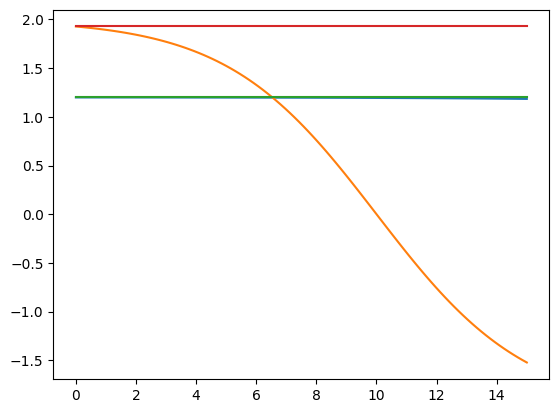

In [5]:
x_plot = np.linspace(0, 15, 100)
X = np.array([x_plot, x_plot])
F1 = np.array([f_10(x) for x in X.T])
plt.plot(x_plot, F1)

X = np.array([x_plot, x_plot])
F2 = np.array([f_01(x) for x in X.T])
plt.plot(x_plot, F2)

# diagonal elements
X = np.array([x_plot, x_plot])
F1 = np.array([f_00(x) for x in X.T])
plt.plot(x_plot, F1)

X = np.array([x_plot, x_plot])
F2 = np.array([f_11(x) for x in X.T])
plt.plot(x_plot, F2)

In [6]:
fp.size()

TypeError: 'int' object is not callable

In [ ]:
np.linalg.solve(Win, np.array([1,2]))

In [ ]:
y = node2.get_weights()
a, b, c, d, e = [x.detach().numpy() for x in y]

In [ ]:
a

In [ ]:
np.matmul(W1, x)

In [ ]:
W1

In [ ]:
eqBound = np.array([[1,2],[3,4],[6,7]])
gridDensity = 3
coordinateIntervals = [np.linspace(*interval, num=gridDensity) for interval in eqBound]
evalGrid = np.meshgrid(*coordinateIntervals)
X = np.column_stack([G_i.flatten() for G_i in evalGrid])

In [ ]:
X

In [ ]:
node2.phase_portrait()
node2.plot()

In [ ]:
x = np.array([1,2,3,4])

In [ ]:
x.astype(float)

In [7]:
np.linalg.solve(np.array([[1.2, 3],[2.4, 8]]), np.array([1, 1]))

array([ 2.08333333, -0.5       ])